In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import Ridge
from tqdm import tqdm

from hola.tune import tune

In [2]:
symbols = [
    "IVV",
    "IJR",
    "IVW",
    "IUSV",
    "HDV",
    "EEM",
    
    "AGG",
    "HYG",
    
    "IAU",
    "GSG"
]

num_symbols = len(symbols)

start = "2007-01-01"
end = "2022-01-20"

In [3]:
dfs = []
for S in symbols:
    print(S)
    stock = yf.Ticker(S)
    df = stock.history(start=start,end=end)
    df[f'{S}'] = df['Close']
    df = df.fillna(method='ffill')
    dfs.append(df[[f'{S}']])
    
df_close = pd.concat(dfs,axis=1).bfill()

IVV
IJR
IVW
IUSV
HDV
EEM
AGG
HYG
IAU
GSG


In [4]:
df_close

,IVV,IJR,IVW,IUSV,HDV,EEM,AGG,HYG,IAU,GSG
Date,,,,,,,,,,
2007-01-03,105.400841,27.038229,13.115377,25.241730,34.811584,28.473915,63.845345,40.821075,12.460000,38.400002
2007-01-04,105.683670,27.017712,13.151824,25.227636,34.811584,28.080709,63.979542,40.821075,12.344000,37.150002
2007-01-05,104.872406,26.718193,13.103229,25.030373,34.811584,27.259676,63.934776,40.821075,12.042000,37.480000
2007-01-08,105.311523,26.701790,13.121454,25.084398,34.811584,27.457518,63.973110,40.821075,12.108000,37.400002
2007-01-09,105.222252,26.755119,13.133599,25.004545,34.811584,26.844221,63.973110,40.821075,12.188000,37.220001
...,...,...,...,...,...,...,...,...,...,...
2022-01-12,473.079987,113.070000,81.250000,77.480003,103.529999,50.849998,112.599998,86.480003,34.750000,18.190001
2022-01-13,466.589996,112.970001,79.220001,77.379997,103.070000,50.130001,112.800003,86.169998,34.650002,17.969999
2022-01-14,466.750000,113.489998,79.440002,77.269997,103.500000,50.110001,112.169998,86.089996,34.540001,18.320000


<AxesSubplot:xlabel='Date'>

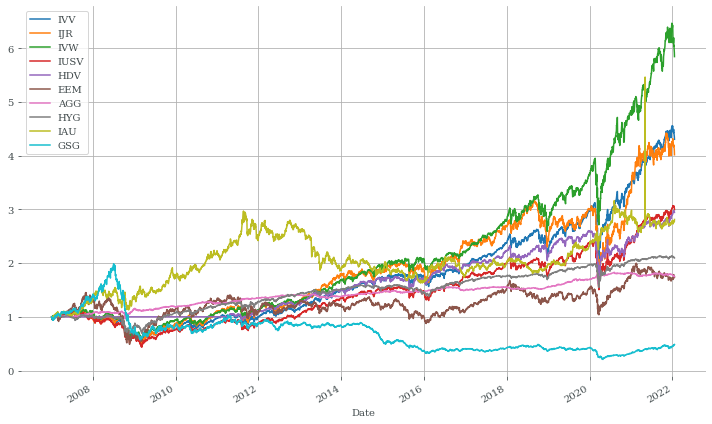

In [5]:
(df_close/df_close.iloc[0]).plot(figsize=(10,6))

In [6]:
df_returns = df_close.pct_change().bfill()
df_returns

,IVV,IJR,IVW,IUSV,HDV,EEM,AGG,HYG,IAU,GSG
Date,,,,,,,,,,
2007-01-03,0.002683,-0.000759,0.002779,-0.000558,0.000000,-0.013809,0.002102,0.000000,-0.009310,-0.032552
2007-01-04,0.002683,-0.000759,0.002779,-0.000558,0.000000,-0.013809,0.002102,0.000000,-0.009310,-0.032552
2007-01-05,-0.007676,-0.011086,-0.003695,-0.007819,0.000000,-0.029238,-0.000700,0.000000,-0.024465,0.008883
2007-01-08,0.004187,-0.000614,0.001391,0.002158,0.000000,0.007258,0.000600,0.000000,0.005481,-0.002134
2007-01-09,-0.000848,0.001997,0.000926,-0.003183,0.000000,-0.022336,0.000000,0.000000,0.006607,-0.004813
...,...,...,...,...,...,...,...,...,...,...
2022-01-12,0.002649,-0.003964,0.004823,0.000129,-0.000579,0.016593,0.000000,0.001622,0.002018,0.011117
2022-01-13,-0.013719,-0.000884,-0.024985,-0.001291,-0.004443,-0.014159,0.001776,-0.003585,-0.002878,-0.012095
2022-01-14,0.000343,0.004603,0.002777,-0.001422,0.004172,-0.000399,-0.005585,-0.000928,-0.003175,0.019477


In [7]:
df_returns_train = df_returns.loc["2007-01-01":"2016-01-01"]

In [8]:
eps = 1e-8
step = 30
tx_cost_actual = 5.0/10000
max_leverage = 1.0
vol_target = 0.1/np.sqrt(265)


def backtest(df_returns, alpha_hl, cov_hl, ridge_reg, train_window, tx_cost_sim, max_long, max_short,
            shrinkage, max_total_long, max_total_short):
    N = df_returns.shape[0]
    num_symbols = df_returns.shape[1]
    
    Y = df_returns.shift(-1).fillna(0.0)
    X = df_returns.ewm(halflife=alpha_hl).mean()
    X_std = df_returns.ewm(halflife=alpha_hl).std().bfill()
    
    X = X.join(X_std, lsuffix='', rsuffix='_std')
    r_actual = df_returns.values

    Cov = df_returns.ewm(halflife=cov_hl).cov().values.reshape((-1,num_symbols,num_symbols))
    Cov[:2] = Cov[2]

    W = np.zeros((N,num_symbols))
    R = np.zeros((N))

    alpha_model = Ridge(alpha=ridge_reg)

    #for t in tqdm(range(train_window,N,step)):
    for t in range(train_window,N,step):
        x_train = X.iloc[t-train_window:t].values
        y_train = Y.iloc[t-train_window:t].values

        alpha_model.fit(x_train, y_train)

        x_test = X.iloc[t:t+step].values

        alpha = alpha_model.predict(x_test)    

        for i in range(len(alpha)):
            w_prev = W[t+i-1]
            C = Cov[i]+eps*np.identity(num_symbols)
            D = np.diag(C)
            C = C*shrinkage
            for k in range(num_symbols): C[k,k] = D[k]
                
            L = np.linalg.cholesky(C)
            w = cp.Variable(num_symbols)

            obj = w@alpha[i] - tx_cost_sim*cp.sum_squares(w-w_prev)

            constr = [
                w <= max_long,
                w >= max_short,
                cp.sum(cp.abs(w)) <= max_leverage,
                cp.norm(L@w) <= vol_target,
                cp.sum(w) <= max_total_long,
                cp.sum(w) >= max_total_short
            ]

            cp.Problem(cp.Maximize(obj), constr).solve()

            W[t+i] = w.value
            R[t+i] = W[t+i]@r_actual[t+i] - tx_cost_actual*np.sum(np.abs(W[t+i]-w_prev))

    return W, R


def sim(alpha_hl, cov_hl, ridge_reg, train_window, tx_cost_sim, max_long, max_short,
       shrinkage, max_total_long, max_total_short):
    W,R = backtest(df_returns_train, alpha_hl, cov_hl, ridge_reg, train_window, tx_cost_sim, max_long, max_short,
                  shrinkage, max_total_long, max_total_short)
    
    cum_ret = np.cumprod(1+R)

    df_met = pd.DataFrame(data=cum_ret, columns=['cum_ret'])
    hwm = df_met.expanding().max()

    max_drawdown = (1.0-df_met/hwm).max().values[0]

    cum_ret = cum_ret[-1]-1

    return {"cum_ret":cum_ret, "max_drawdown":max_drawdown}


In [9]:
params_config = {
    "alpha_hl":{"min":5,"max":60,"param_type":"int"},
    "cov_hl":{"min":40,"max":180,"param_type":"int"},
    "ridge_reg":{"min":1e-3,"max":1e3},
    "train_window":{"min":20,"max":200, "param_type":"int"},
    "tx_cost_sim":{"min":0,"max":1.0},
    "max_long":{"min":0.05,"max":0.25},
    "max_short":{"min":-0.25,"max":-0.05},
    "shrinkage":{"min":0.1, "max":1.0},
    "max_total_long":{"min":0.5,"max":1.0},
    "max_total_short":{"min":-0.5,"max":0.25}
}

objectives_config = {
    "cum_ret": {"target":5.0, "limit":-0.5, "priority":2.0},
    "max_drawdown": {"target":0.0, "limit":1.0, "priority":1.0}
}

In [10]:
tuner = tune(sim, params_config, objectives_config, min_samples=40, num_runs=100, n_jobs=8)

In [11]:
tuner.get_leaderboard()

,run,alpha_hl,cov_hl,ridge_reg,train_window,tx_cost_sim,max_long,max_short,shrinkage,max_total_long,max_total_short,cum_ret,max_drawdown,score
75,75,50,47,807.255878,33,0.263974,0.225303,-0.190412,0.888810,0.500593,-0.080735,1.228930,0.126180,1.497478
103,103,47,40,840.985273,32,0.336207,0.229339,-0.184646,0.891426,0.500000,-0.112525,1.097717,0.128947,1.547960
48,48,44,173,904.977953,69,0.372843,0.182652,-0.210756,0.411256,0.964489,-0.006080,1.124099,0.163829,1.573247
35,35,54,109,397.134221,43,0.326502,0.130806,-0.183105,0.578029,0.919245,0.097779,0.937036,0.104105,1.581547
101,101,33,65,209.455135,25,0.624223,0.161289,-0.120778,0.199677,0.761230,-0.121202,0.907049,0.124916,1.613261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,33,24,72,200.335080,103,0.797775,0.234863,-0.202933,0.163194,0.632137,-0.163344,0.410307,0.310074,1.979053
12,12,58,178,261.542910,171,0.549173,0.244479,-0.199256,0.290611,0.562204,-0.498964,0.343650,0.323682,2.016900
41,41,26,99,919.052920,23,0.084215,0.159024,-0.161580,0.703158,0.946626,-0.399433,0.139530,0.253382,2.020825
71,71,35,70,539.828820,154,0.880201,0.185023,-0.184756,0.991015,0.535717,-0.466508,0.250014,0.306529,2.033797


In [12]:
params = tuner.get_best_params()
params

{'alpha_hl': 50,
 'cov_hl': 47,
 'ridge_reg': 807.2558780737519,
 'train_window': 33,
 'tx_cost_sim': 0.2639736831188202,
 'max_long': 0.22530267238616947,
 'max_short': -0.19041208624839784,
 'shrinkage': 0.8888104736804963,
 'max_total_long': 0.5005932971835136,
 'max_total_short': -0.08073532581329346}

In [13]:
df_returns_test = df_returns.loc["2016-01-01":]
W,R = backtest(df_returns_test, **params)

<AxesSubplot:xlabel='Date'>

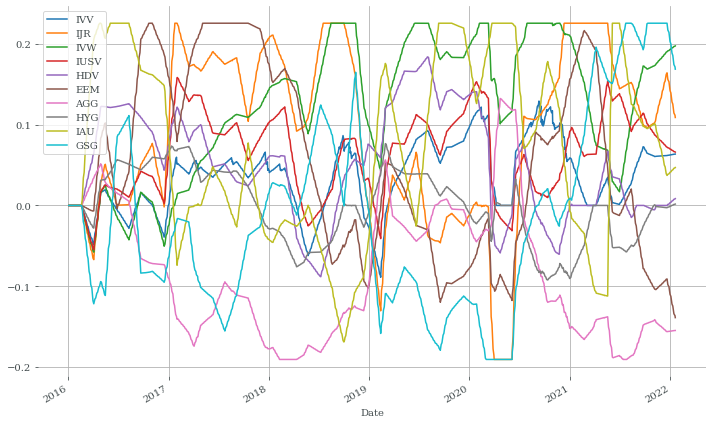

In [14]:
df_w = pd.DataFrame(index=df_returns_test.index, columns=df_returns.columns, data=W)
df_w.plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

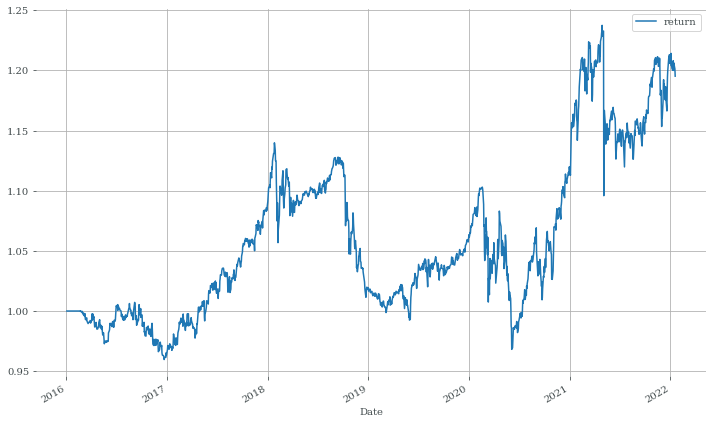

In [15]:
df_r = pd.DataFrame(index=df_returns_test.index, columns=['return'], data=R)

(1+df_r).cumprod().plot(figsize=(10,6))

In [16]:
np.mean(R)/np.std(R)*np.sqrt(255)

0.3527575265238123